In [1]:
from DLtools.Trial_evaluation_rec import real_eva_error
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
import pywt
np.random.seed(42)
############# Keras ###################
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #ignore cuDNN log
#---------------------------------------
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/song/anaconda3/envs/tf-gpu-c

In [2]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 72,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
DLtype = 'split_4wave'

In [3]:
#--------------------------- 2 Yr Edit -----------------------------------#
host_path = './CPY012/2Yr_flood/'
start_p = '2016-01-01'
split_date = '2017-05-10'
stop_p = '2018-01-01'
n_pca = 7

syn=''
# Yscale = False # scaler Y before put in model 
allscale = True # scale X before put in model
w_std = False # standardize before wavelet transform

#-----------------------Baseline / Hybrid -----------------------------------#
save_path =host_path+'Trial'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [4]:
#Split XY
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        # past= DWT_seq_tran(past)
        # future = DWT_seq_tran(future)
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
def split_xy(data,n_past,n_future):
    x,y = split_series(data.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],n_features))
    y = y[:,:,0]
    return x,y

##--------------added Wavelet ---------------##
def wavelet_t(series,std):
    name = series.name
    idx = series.index
    signal = series.values
    if std: signal = (signal - signal.mean())/(signal.std())

    coeff = pywt.swt(signal,'db4',level=3)
    coeff = np.array(coeff)

    cA3,cD3 = coeff[0][0],coeff[0][1]
    _,cD2 = coeff[1][0],coeff[1][1]
    _,cD1 = coeff[2][0],coeff[2][1]
    #----------------------------
    dict_data = {
            # name:signal,
            '{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
    wt = pd.DataFrame(dict_data,dtype='float32',index=idx)
    return wt
def df_wavelet(df,std):
    global syn
    syn = syn+'[wav]'
    wav_df = pd.DataFrame()
    for col in df:
        a = wavelet_t(df[col],std)
        wav_df = pd.concat([wav_df,a],axis=1)
    return wav_df
def inverse_WT(coeffs_list):
    wav=list()
    for i in range(coeffs_list[0].shape[0]):
        iwave = pywt.iswt([coeff[i,:] for coeff in coeffs_list],'db4')
        wav.append(iwave)
    return np.array(wav)

In [5]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 24*7,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)

In [6]:
#------------------------- Main ---------------------------------#
df = df[start_p:stop_p]
data = df
data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

if w_std: syn=syn+'[w_std]'
wdata = df_wavelet(data_mar,w_std)


# Split triantest

In [7]:

def extract_target_signal(data,staion):
    def st_column_select(data,staion):
        data_col = [i.split("_") for i in data.columns]
        _col =list()
        for i in data_col:
            if i[0]==staion : 
                i='_'.join(i)
                _col.append(i)
        return data[_col]
    cpy = st_column_select(data,staion)
    #Put in function latter
    train,test = cpy[:split_date],cpy[split_date:]
    x,y = split_series(train.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],4))
    yA3_train = y[:,:,0]
    yD3_train = y[:,:,1]
    yD2_train = y[:,:,2]
    yD1_train = y[:,:,3]
    #--------------------------------------------
    x,y = split_series(test.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],4))
    yA3_test = y[:,:,0]
    yD3_test = y[:,:,1]
    yD2_test = y[:,:,2]
    yD1_test = y[:,:,3]
    #------------------------------------------
    yA3 = [yA3_train,yA3_test]
    yD3 = [yD3_train,yD3_test]
    yD2 = [yD2_train,yD2_test]
    yD1 = [yD1_train,yD1_test]
    return yA3,yD3,yD2,yD1


In [8]:
yA3_ori,yD3_ori,yD2_ori,yD1_ori= extract_target_signal(wdata,'CPY012')

In [9]:
##-------add ------- Select degree 
def syn_column_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    _col =list()
    for i in data_col:
        if i[2]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]
data_cA3 = syn_column_select(wdata,'cA3')
data_cD3 =syn_column_select(wdata,'cD3')
data_cD2 = syn_column_select(wdata,'cD2')
data_cD1 = syn_column_select(wdata,'cD1')

<AxesSubplot:xlabel='date'>

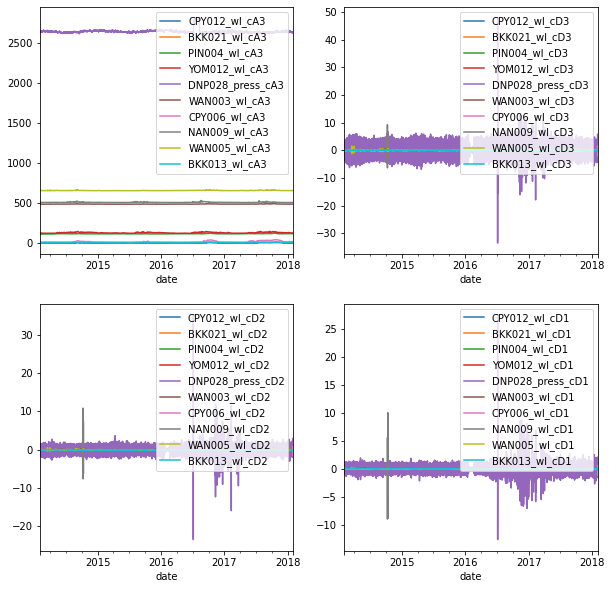

In [10]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
data_cA3.plot(ax=ax[0][0])
data_cD3.plot(ax=ax[0][1])
data_cD2.plot(ax=ax[1][0])
data_cD1.plot(ax=ax[1][1])

# Deeplearning 

In [11]:
def run_code_editv2(model,X,Y,batch_size):
    global target,mode
    verbose, epochs = 1, 100
    history = model.fit(X[0],Y[0],epochs=epochs,validation_data=(X[1],Y[1]),batch_size=batch_size,verbose=verbose,callbacks=callbacks)
    def history_plot(history_model,name):   
        fig, ax = plt.subplots(figsize=(6.4, 4.8))
        ax.plot (history_model.history['loss'])
        ax.plot (history_model.history['val_loss'])
        ax.set_title ('model loss:{}'.format(name))
        ax.set_xlabel('epoch')
        ax.legend(['train','val'],loc='upper left')
        fig.savefig(save_path+'/loss_{}.png'.format(name), dpi=100, bbox_inches='tight') 
        fig.clear()
        plt.close(fig)
    history_plot(history,syn)    

    trainPredict = model.predict(X[0])
    testPredict = model.predict(X[1])
    return trainPredict,testPredict

In [12]:
def record_list_result(syn,df,mode,trainY,testY,trainPredict,testPredict,target,batch_size,save_path,n_past,n_features,n_future=1):
    idx=None
    for d in range(n_future):
        st_idx = n_past+d
        Y_tr= pd.Series(data=trainY[:,d],index=df[:split_date].index[st_idx:len(trainY)+st_idx])
        Yhat_tr = pd.Series(data=(trainPredict[:,d].ravel()),index=df[:split_date].index[st_idx:len(trainY)+st_idx])        
        Y_t= pd.Series(data=testY[:,d],index=df[split_date:].index[st_idx:len(testY)+st_idx])
        Yhat_t = pd.Series(data=(testPredict[:,d].ravel()),index=df[split_date:].index[st_idx:len(testY)+st_idx])

        mse,nse,r2,rmse,mae = real_eva_error(Y_tr, Yhat_tr,)
        Tmse, Tnse,Tr2,Trmse,Tmae = real_eva_error(Y_t, Yhat_t,)
        #------------ Plot trian-test ------------------#
        syn_new = syn+'_t'+str(d+1)
        if d in [0,11,23,47,71]: 
            plotgraph(target,save_path,Y_tr,Y_t,Yhat_tr,Yhat_t,syn_new) 
            plot_moonson_l(save_path,Y_tr,Y_t,Yhat_tr,Yhat_t,syn)
            plot_rsquare(save_path,Y_t,Yhat_t,syn_new)

        mon_df = monsoon_cal(Y_tr,Y_t,Yhat_tr,Yhat_t,syn_new) 
        
        
        #-----------------------
        print('{} saved !'.format(d+1))
        #---------------------
        dict_data = {'note':mode,'Model':syn,'timestep':d+1,'Feature':n_features,'Time_in':n_past,'Time_out':n_future,'Batch':batch_size,
                    'MSE_trian':mse,'Rmse_trian':rmse,'NSE_train':nse,'R2_train':r2,'MAE_train':mae,
                    'MSE_test':Tmse,'Rmse_test':Trmse,'NSE_test':Tnse,'R2_test':Tr2,'MAE_test':Tmae} 
        _df = pd.DataFrame.from_dict(data=dict_data, orient ='index')
        _df = pd.concat([_df,mon_df])
        
        idx=_df.index
        
        _df.reset_index(drop=True, inplace=True)
        error.reset_index(drop=True, inplace=True)
        error = pd.concat([error,_df],axis=1)
        try: 
            error.set_index(idx,inplace=True)
        except:
            idx=idx.insert(0,'0')
            error.set_index(idx,inplace=True)
    return error.T

In [13]:
def wav_dl_wav_run(model_list,batch,syn):
    def autosplit(data):    
        ##----------- train test split 
        train,test = data[:split_date],data[split_date:]
        # ##--------- Wavelet_traintest
        X_train, y_train = split_xy(train,n_past,n_future)
        X_test, y_test= split_xy(test,n_past,n_future)
        return [X_train,X_test],[y_train,y_test]
    
    X,_=autosplit(data_cA3)
    cA3ytrain,cA3ytest = run_code_editv2(model_list[0],X,yA3_ori,batch)
    X,_=autosplit(data_cD3)
    cD3ytrain,cD3ytest = run_code_editv2(model_list[1],X,yD3_ori,batch)
    X,_=autosplit(data_cD2)
    cD2ytrain,cD2ytest = run_code_editv2(model_list[2],X,yD2_ori,batch)
    X,_=autosplit(data_cD1)
    cD1ytrain,cD1ytest = run_code_editv2(model_list[3],X,yD1_ori,batch)

    trainPredict = inverse_WT([cA3ytrain,cD3ytrain,cD2ytrain,cD1ytrain])
    testPredict = inverse_WT([cA3ytest,cD3ytest,cD2ytest,cD1ytest])

    _,Y=autosplit(data_mar)
    y_train,y_test = Y[0],Y[1]
    record_list_result(syn,df,DLtype,y_train,y_test,trainPredict,testPredict,target,batch_size,save_path,n_past,n_features,n_future)

# Deep learning

In [52]:
#------------ DL PARAMETER ---------------------#
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=2, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]

In [54]:
#----------------------------------------------------------#
def build_lstm():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss=loss_f, optimizer=my_optimizer)
    model.summary()
    return model
#-------------------------------------------------------------#
def build_lstm_batch():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss=loss_f, optimizer=my_optimizer)
    model.summary()
    return model
#------------------------------------------------------------#
def build_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer=my_optimizer, loss=loss_f)    
    model.summary()
    return model
#-------------------------------------------------------------#
def build_ann():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Flatten()(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(144, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer=my_optimizer, loss=loss_f)    
    model.summary()
    return model
#-------------------------------------------------------------#

In [141]:
def showresult(Yhat,Y):
    print(forecast_accuracy(Yhat[0],Y[0]))
    print(forecast_accuracy(Yhat[1],Y[1]))

    for i in range(72):
        plt.title(syn)
        plt.plot(Y[1][:,i],color='blue',alpha=0.1)
        plt.plot(Yhat[1][:,i],color='red',alpha=0.2)
    plt.legend()

#  [transform]> [wav] > [DL] > [wav] > [Inversetransform] 

<AxesSubplot:xlabel='date'>

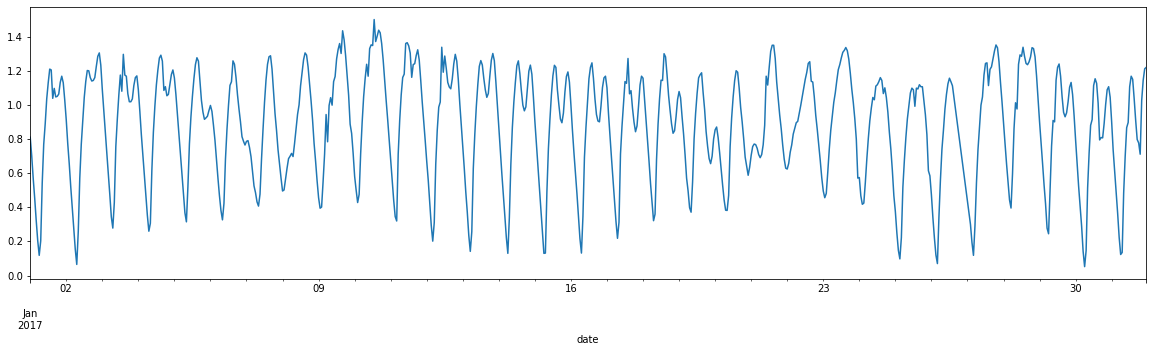

In [17]:
data_mar[target]['2017-01':'2017-01'].plot(figsize=(20,5))

<AxesSubplot:xlabel='date'>

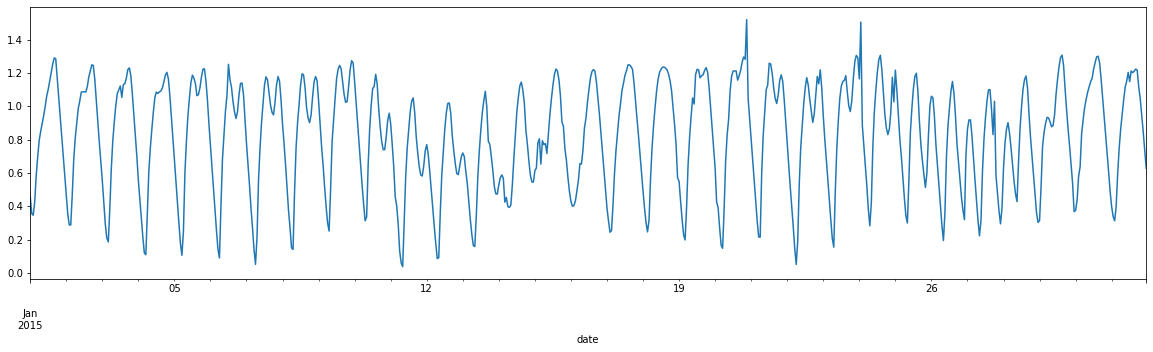

In [20]:
data_mar[target]['2015-01':'2015-01'].plot(figsize=(20,5))

In [ ]:
data_mar[target]

monsoon = [8,9,10]
fig,ax =  plt.subplots(2,1,figsize=(6.4, 4.8))
fig.autofmt_xdate(rotation=45)
sel_m = data_mar.iloc[(trainY.index.month.isin(monsoon))]
Tsel_m = trainPredict.iloc[(trainPredict.index.month.isin(monsoon))]

sel_2016 = sel_m.iloc[(sel_m.index.year.isin([2016]))]
Tsel_2016 = Tsel_m.iloc[(Tsel_m.index.year.isin([2016]))]
ax[0].plot(sel_2016,label='Y_2016')
ax[0].plot(Tsel_2016,label='Yhat_2016')
ax[0].set_title(' Year 2016')
ax[0].legend(loc='upper left')

sel_m = testY.iloc[(testY.index.month.isin(monsoon))]
Tsel_m = testPredict.iloc[(testPredict.index.month.isin(monsoon))]
sel_2017 = sel_m.iloc[(sel_m.index.year.isin([2017]))]
Tsel_2017 = Tsel_m.iloc[(Tsel_m.index.year.isin([2017]))]
ax[1].plot(sel_2017,label='Y_2017')
ax[1].plot(Tsel_2017,label='Yhat_2017')
ax[1].set_title('Year 2017')
ax[1].legend(loc='upper left')

plt.tight_layout()

plot_out(monsoon,True)
general_zoom = [3,4,5]
plot_out(general_zoom,False)

# Reserve

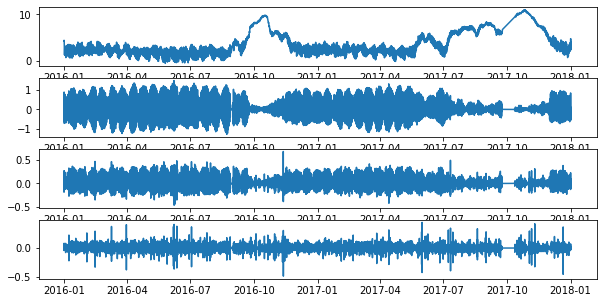

In [45]:
#std_sc = StandardScaler()
#cpy[cpy.columns] = std_sc.fit_transform(cpy[cpy.columns])

fig,ax = plt.subplots(4,1, figsize=(10,5))
for i in range(cpy.shape[1]):
    ax[i].plot(cpy.iloc[:,i])

<AxesSubplot:xlabel='date'>

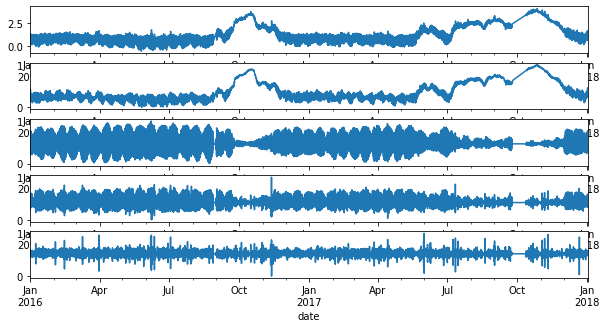

In [46]:
fig,ax = plt.subplots(5,1, figsize=(10,5))
data_mar.iloc[:,0].plot(ax=ax[0])
wdata_A3.iloc[:,0].plot(ax=ax[1])
wdata_D3.iloc[:,0].plot(ax=ax[2])
wdata_D2.iloc[:,0].plot(ax=ax[3])
wdata_D1.iloc[:,0].plot(ax=ax[4])